<a href="https://colab.research.google.com/github/Ankityadav98/Twitter-Sentiment-Analysis-Competition-by-Analytics-Vidhya/blob/master/Improvised_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd '/content/gdrive/My Drive/ML/Sentiment analysis dataset'

/content/gdrive/My Drive/ML/Sentiment analysis dataset


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [ ]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [ ]:
train['label'].value_counts()

0    5894
1    2026
Name: label, dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


In [ ]:
df= pd.concat([train,test],axis=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9873 entries, 0 to 1952
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      9873 non-null   int64  
 1   label   7920 non-null   float64
 2   tweet   9873 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 308.5+ KB


In [ ]:
#!pip install -U spacy

In [ ]:
#!python -m spacy download en


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
import re
import spacy
sp = spacy.load('en_core_web_sm')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemma= WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def clean_data(text):
  #remove emails
  text = ' '.join([i for i in text.split() if '@' not in i])
    
  #remove web address
  text = re.sub('http[s]?://\S+', '', text)
    
  #Filter to allow only alphabets
  text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
  #Remove Unicode characters
  text = re.sub(r'[^\x00-\x7F]+', '', text)
    
  #Convert to lowercase to maintain consistency
  text = text.lower()
    
  #Remove stopwords
  all_stopwords = sp.Defaults.stop_words
  text_tokens = word_tokenize(text)
  tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]
  text=' '.join(tokens_without_sw)
  
  #lemmatization
  text= [lemma.lemmatize(w) for w in tokens_without_sw]
  text= ' '.join(text)
  
  #remove double spaces 
  text = re.sub('\s+', ' ',text)
  return (text)

In [ ]:
df.head()

,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...


In [ ]:
df['clean_tweet']= df['tweet'].apply(clean_data)

In [ ]:
print(df['tweet'].iloc[4])
print(df['clean_tweet'].iloc[4])

What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!
amazing service apple wo talk question pay stupid support


In [ ]:
df.isna().sum()

id                0
label          1953
tweet             0
clean_tweet       0
dtype: int64

In [ ]:
train.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [ ]:
train_new= df[:7920].copy()
test_new= df[7920:].copy()

In [ ]:
train_new.drop(columns=['id','tweet'],inplace=True)
train_new['label']=train_new['label'].astype(int)
train_new.head()

,label,clean_tweet
0,0,fingerprint pregnancy test android apps beauti...
1,0,finally transparant silicon case thanks uncle ...
2,0,love talk makememories unplug relax iphone sma...
3,0,wired know george way iphone cute daventry home
4,1,amazing service apple wo talk question pay stu...


In [ ]:
test_new.drop(columns=['label','tweet'],inplace=True)
test_new.head()

,id,clean_tweet
0,7921,hate new iphone upgrade wo let download apps u...
1,7922,currently shitting fucking pant apple imac cas...
2,7923,like put cd rom ipad possible ' yes block screen
3,7924,ipod officially dead lost picture video d so c...
4,7925,fighting itunes night want music paid


In [ ]:
train_new= train_new.reindex(np.random.permutation(train_new.index))
train_new= train_new.reset_index(drop=True)

In [ ]:
corpus=[]
labels=[]
for i in range(len(train_new)):
  corpus.append(train_new['clean_tweet'][i])
  labels.append(train_new['label'][i])

In [ ]:
test_portion=0.2
split=int(test_portion*len(train_new))

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

In [ ]:
oov_token='<OOV>'
pad_type='post'
trunc_type='post'
embedding_dim=50
max_length= 150 #max([len(x) for x in corpus])

In [ ]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index= tokenizer.word_index
vocab_size= len(word_index)
print(vocab_size)

sequences= tokenizer.texts_to_sequences(corpus)
padded= pad_sequences(sequences,maxlen=max_length,padding=pad_type,truncating=trunc_type)

val_sequences = padded[0:split]
train_sequences = padded[split:]
val_labels = labels[0:split]
train_labels = labels[split:]

15653


In [ ]:
embeddings_index = {};
with open('/content/gdrive/My Drive/ML/GloVe/glove.6B.50d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1,embedding_dim,input_length=max_length,weights=[embeddings_matrix], trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

adam= Adam(0.001)
model.compile(loss='binary_crossentropy',optimizer=adam ,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           782700    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 150, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 826,365
Trainable params: 43,665
Non-trainable params: 782,700
_________________________________________________________________


In [ ]:
num_epochs = 20
training_padded= np.array(train_sequences)
training_labels= np.array(train_labels)
val_padded=  np.array(val_sequences)
val_labels= np.array(val_labels)

In [ ]:
history = model.fit(training_padded,training_labels, epochs=num_epochs, validation_data=(val_padded,val_labels), verbose=1)

Epoch 1/20
198/198 [==============================] - 4s 23ms/step - loss: 0.4482 - accuracy: 0.7874 - val_loss: 0.3541 - val_accuracy: 0.8636
Epoch 2/20
198/198 [==============================] - 4s 19ms/step - loss: 0.3514 - accuracy: 0.8333 - val_loss: 0.3315 - val_accuracy: 0.8605
Epoch 3/20
198/198 [==============================] - 4s 18ms/step - loss: 0.3327 - accuracy: 0.8483 - val_loss: 0.2752 - val_accuracy: 0.8813
Epoch 4/20
198/198 [==============================] - 4s 18ms/step - loss: 0.3168 - accuracy: 0.8562 - val_loss: 0.2833 - val_accuracy: 0.8737
Epoch 5/20
198/198 [==============================] - 4s 18ms/step - loss: 0.3108 - accuracy: 0.8619 - val_loss: 0.2680 - val_accuracy: 0.8782
Epoch 6/20
198/198 [==============================] - 4s 18ms/step - loss: 0.3044 - accuracy: 0.8622 - val_loss: 0.2511 - val_accuracy: 0.8965
Epoch 7/20
198/198 [==============================] - 4s 18ms/step - loss: 0.2962 - accuracy: 0.8679 - val_loss: 0.2571 - val_accuracy: 0.8946

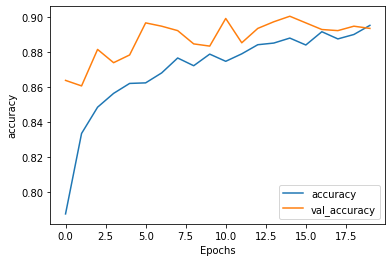

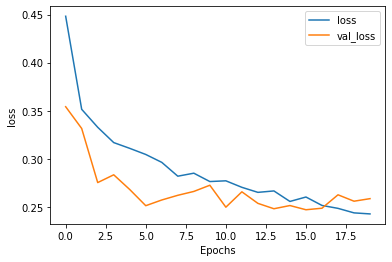

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
padded= np.array(padded)
labels= np.array(labels)

model_final = Sequential()
model_final.add(Embedding(vocab_size+1,embedding_dim,input_length=max_length,weights=[embeddings_matrix], trainable=False))
model_final.add(SpatialDropout1D(0.3))
model_final.add(Bidirectional(LSTM(50)))
model_final.add(Dense(32, activation='relu'))
model_final.add(Dense(1,activation='sigmoid'))
model_final.compile(loss='binary_crossentropy',optimizer=adam ,metrics=['accuracy'])
model_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 50)           782700    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 826,365
Trainable params: 43,665
Non-trainable params: 782,700
_________________________________________________________________


In [ ]:
history = model_final.fit(padded, labels, epochs=num_epochs, verbose=1)

Epoch 1/20
248/248 [==============================] - 4s 18ms/step - loss: 0.3640 - accuracy: 0.8332
Epoch 2/20
248/248 [==============================] - 4s 17ms/step - loss: 0.2992 - accuracy: 0.8683
Epoch 3/20
248/248 [==============================] - 4s 17ms/step - loss: 0.2801 - accuracy: 0.8794
Epoch 4/20
248/248 [==============================] - 4s 17ms/step - loss: 0.2705 - accuracy: 0.8808
Epoch 5/20
248/248 [==============================] - 4s 17ms/step - loss: 0.2639 - accuracy: 0.8836
Epoch 6/20
248/248 [==============================] - 4s 17ms/step - loss: 0.2551 - accuracy: 0.8855
Epoch 7/20
248/248 [==============================] - 4s 17ms/step - loss: 0.2547 - accuracy: 0.8846
Epoch 8/20
248/248 [==============================] - 4s 17ms/step - loss: 0.2431 - accuracy: 0.8931
Epoch 9/20
248/248 [==============================] - 4s 17ms/step - loss: 0.2332 - accuracy: 0.8985
Epoch 10/20
248/248 [==============================] - 4s 17ms/step - loss: 0.2292 - accura

In [ ]:
test_corpus=[]
for i in range(len(test_new)):
  test_corpus.append(test_new['clean_tweet'][i])

test_sequences= tokenizer.texts_to_sequences(test_corpus)
test_padded= pad_sequences(test_sequences,maxlen=max_length,padding=pad_type,truncating=trunc_type)

test_padded= np.array(test_padded)

In [ ]:
predictions= (model_final.predict(test_padded)>0.5).astype(int)

In [ ]:
file= pd.read_csv('sample_submission.csv')

In [ ]:
file.head()

,id,label
0,7921,0
1,7922,0
2,7923,0
3,7924,0
4,7925,0


In [ ]:
file['label']= (predictions>0.5).astype(int)

In [ ]:
file.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,0
4,7925,1


In [ ]:
file.to_csv('final_subm.csv',index=False,header=True)